https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

notebooks_path = '../nbs/'
input_path = '../input/'
output_path = '../output/'
print(os.listdir(input_path))


# Any results you write to the current directory are saved as output.

['.gitignore', 'sample_submission.csv', 'test.csv', 'train.csv', 'zip']


In [31]:
#! pip install numba
from numba import jit

# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

## Loading data set files


In [5]:
train_dataset = pd.read_csv(input_path + 'train.csv')
test_dataset = pd.read_csv(input_path + 'test.csv')
print('Train ({} rows), and test ({} rows) data sets were loaded'.format(train_dataset.shape[0], test_dataset.shape[0]))

Train (595212 rows), and test (892816 rows) data sets were loaded


## Data Exploration
Let's check the size, types  of the train and test data sets.
* Data sets size - how many rows and columns each data set contains
* What are the data types
* Missing values - how many where they are


In [7]:
train_dataset.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


## Counting how many columns from each data type we have:

In [8]:
# Return a table with a count of all columns types 
def explore_dtypes(df):
    types = pd.DataFrame(df.dtypes, columns=['Column Data Type'])
    types['Count'] = types.index
    types.reset_index(drop=True, inplace=True)
    return types.groupby(by=['Column Data Type']).count()
    
print('Columns count by data type\n\nTrain set:')
display(explore_dtypes(train_dataset))    

print('\n*************\nTest set:')
display(explore_dtypes(test_dataset))

Columns count by data type

Train set:


,Count
Column Data Type,
int64,49
float64,10



*************
Test set:


,Count
Column Data Type,
int64,48
float64,10


* The data contains only columns of types **int64** and **float64**.
* Train and test sets data types look the same*. 

 \*The only diffence is that the train set contains 1 extra column, as expectedwhich is the **'target'** column (labels, type int64).

In [9]:
diff_cols = [col for col in train_dataset.columns if col not in test_dataset.columns]
print ('Columns that in the train set and not in the test set:', diff_cols)


Columns that in the train set and not in the test set: ['target']


In [10]:
display('Train', train_dataset.describe())
display('-------\n\nTest', test_dataset.describe())

'Train'

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'-------\n\nTest'

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,...,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,1.358613,4.413734,0.417361,0.408132,0.393246,0.257191,0.163659,0.185905,...,5.438478,1.440265,2.875013,7.540367,0.123720,0.627756,0.554660,0.287796,0.349344,0.152428
std,4.296830e+05,1.986503,0.663002,2.700149,0.493453,1.355068,0.488471,0.437086,0.369966,0.389030,...,2.330081,1.200620,1.694072,2.745882,0.329262,0.483403,0.497004,0.452736,0.476763,0.359435
min,0.000000e+00,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.720218e+05,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.443070e+05,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.116308e+06,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488026e+06,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,20.000000,11.000000,15.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploring Missin Values
### Basic exploration of which columns have missing data and in which ratio.
Will be usfull for feature exploration and data cleaning.
* Replacing -1 with np.nan (Null)
 * missing values represented as '-1' in all the columns in the data set (taken from the official data description [link][http://sss.sss]).
 * Need to be replaced to np.nan in order to use pandas built in functions.
* Counting missing values by column.
* Displaying count and ratio of missing values of each column that has missing values.
* Displaying the ratio of missing values for the intire data set.

### Conclusions
Both train set and test set have simmiller total missing value ratio.

~2.4% of the data is missing in each of them.

Both train set and test set have missing values in the same columns* and with very simmiller ratio per column.

*There is one column,'ps_car_12' , that contains only one missing value, and only in the train set.

Some columns only have a small amount of missing values while others have high ratio of nulls.

The two most "problematic" columns are **'ps_car_o3_cat'**(~69%) and **'ps_car_05_cat'**(~44%) in both train and test sets.


------
# remove
There are 59 columns, 13 of them have missing values (train set).

There are 58 columns, 12 of them have missing values (test set).




Train set:
There are 846458 missing values (2.41% of the data)
Out of 59 columns, 13 columns have missing values
The column "ps_car_03_cat" has the highest ratio of missing values (~69.09%)


,Nulls_count,Nulls_ratio
ps_car_03_cat,411231,69.090
ps_car_05_cat,266551,44.783
ps_reg_03,107772,18.106
ps_car_14,42620,7.160
ps_car_07_cat,11489,1.930
ps_ind_05_cat,5809,0.976
ps_car_09_cat,569,0.096
ps_ind_02_cat,216,0.036
ps_car_01_cat,107,0.018
ps_ind_04_cat,83,0.014


****
****

Test set:
There are 1270295 missing values (2.45% of the data)
Out of 58 columns, 12 columns have missing values
The column "ps_car_03_cat" has the highest ratio of missing values (~69.097%)


,Nulls_count,Nulls_ratio
ps_car_03_cat,616911,69.097
ps_car_05_cat,400359,44.842
ps_reg_03,161684,18.109
ps_car_14,63805,7.146
ps_car_07_cat,17331,1.941
ps_ind_05_cat,8710,0.976
ps_car_09_cat,877,0.098
ps_ind_02_cat,307,0.034
ps_car_01_cat,160,0.018
ps_ind_04_cat,145,0.016


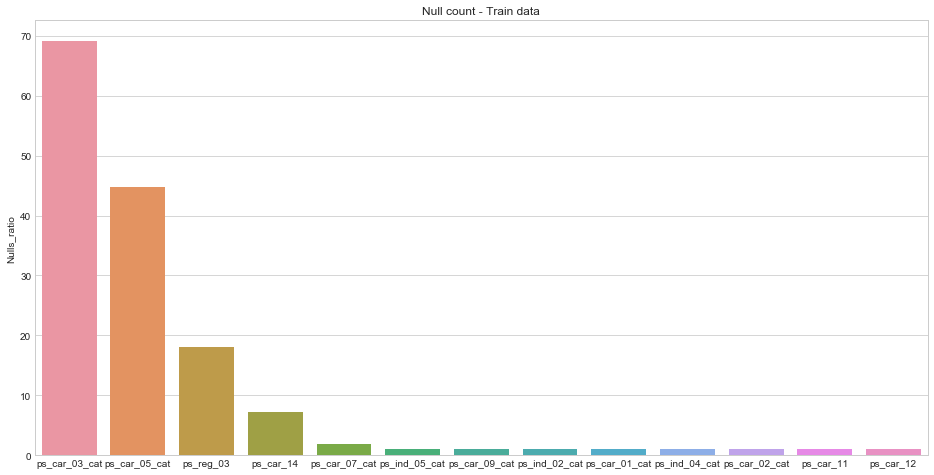

In [11]:
from IPython.display import display, HTML
def explore_missing_values(ds):
    # Replacing '-1' with np.nan (null)
    ds.replace(-1, np.nan, inplace= True)

    # Counting mising values (nulls) for each column and displaying the columns orderd by nulls count
    rows = ds.shape[0] 
    columns = ds.shape[1]
    na_df = pd.DataFrame(ds.isnull().sum(), columns=['Nulls_count'])
    na_df['Nulls_ratio'] = np.round((na_df['Nulls_count'] / rows) * 100, 3)
    na_df.drop(na_df[na_df['Nulls_count'] == 0].index, axis=0, inplace=True)
    na_df.sort_values(by=['Nulls_count'], ascending=False, inplace=True)

    # Total missing values count and ratio
    nulls_count = ds.isnull().sum().sum()
    total_missing_ratio = np.round((nulls_count / (rows * columns)) * 100, 2)
    print('There are {} missing values ({}% of the data)'.format(nulls_count, total_missing_ratio))
    print('Out of {} columns, {} columns have missing values'.format(columns, len(na_df)))
    print('The column "{}" has the highest ratio of missing values (~{}%)'.format(na_df.index[0], na_df.iloc[0,1]))
    return na_df
print('Train set:')
nulls_df = explore_missing_values(train_dataset)
display(nulls_df)
print('****\n****\n\nTest set:')
display(explore_missing_values(test_dataset))

# Bar chart of training data
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('Null count - Train data')    

# Values that are less than 1% are rounded to 1% for better chart display
nulls_df.loc[nulls_df[nulls_df['Nulls_ratio']<1].index, ['Nulls_ratio']] = 1 
sns.barplot(x=nulls_df.index, y=nulls_df['Nulls_ratio'], ax=ax)
#ax.set_ylabel('Unique values count')

## Outlier detection and removal


The data contains numerical values, categriacal features and binary features.

The type of the feature can be detected by the column name prefix (from data description[link][0])

In [12]:
features = train_dataset.columns[2:]
categorical_features = [col for col in features if '_cat' in col]
binary_features = [col for col in features if '_bin' in col]
numeric_features = [col for col in features if '_cat' not in col and '_bin' not in col]

print('{} Categorical features:\n{}'.format(len(categorical_features),categorical_features))
print('\n{} Binary features:\n{}'.format(len(binary_features), binary_features))
print('\n{} Numeric features:\n{}'.format(len(numeric_features), numeric_features))

14 Categorical features:
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']

17 Binary features:
['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']

26 Numeric features:
['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']


## Outlier detection - Need to check if processing it after filling missing values (nulls) gives better results

In [13]:
# Outlier detection 
from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v >= n )
    
    print('There are {0} rows ({2:.2f}%) that contains at least {1} outliers each'.format(len(multiple_outliers), n,100 * len(multiple_outliers)/len(df)))
    return multiple_outliers   

# detect outliers in numeric_features
Outliers_to_drop = detect_outliers(train_dataset.dropna(axis=0), 6,numeric_features)
display(train_dataset.ix[Outliers_to_drop, numeric_features])
display(train_dataset[numeric_features].describe())


There are 7 rows (0.01%) that contains at least 6 outliers each


C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
526413,0,2,0,8,0.9,1.8,2.149855,3.0,0.616441,1.396180,...,2,7,1,10,2,8,4,0,2,4
265254,7,11,0,6,0.0,1.6,1.750000,0.0,0.632456,0.922929,...,2,7,5,8,3,14,10,4,2,13
267587,7,3,0,6,0.9,1.8,1.999219,3.0,0.616441,1.396912,...,3,8,2,10,2,11,4,1,4,16
404470,6,9,0,5,0.9,1.6,1.714643,0.0,0.624980,0.661016,...,0,6,5,8,1,8,5,0,2,15
147977,7,6,0,9,0.9,1.8,1.868321,0.0,0.632139,0.678492,...,5,8,3,10,2,10,5,4,2,6
181546,0,5,0,10,0.9,1.8,2.038995,3.0,0.663325,2.664396,...,2,7,2,9,4,7,6,1,4,16
581666,4,4,1,6,0.9,0.5,0.884944,3.0,0.692820,1.991485,...,2,8,4,6,1,10,4,0,4,14


,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,487440.000000,595207.000000,595211.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,0.610991,0.439184,0.894047,2.346100,0.379947,0.813265,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.287643,0.404264,0.345413,0.832495,0.058300,0.224588,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.000000,0.100000,0.250619,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,0.400000,0.200000,0.633443,2.000000,0.316228,0.670867,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,0.700000,0.300000,0.801561,3.000000,0.374166,0.765811,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,0.900000,0.600000,1.083974,3.000000,0.400000,0.906190,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,0.900000,1.800000,4.037945,3.000000,1.264911,3.720626,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


## Feature analysis
### Numerical values


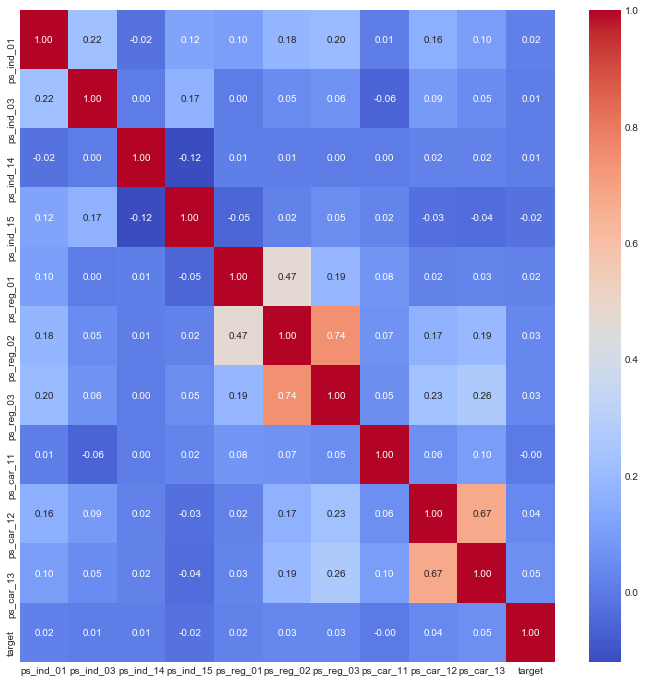

In [14]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
corr_features = numeric_features[:10].copy()
corr_features.append('target')
fig, ax = plt.subplots(figsize=(12,12))
g = sns.heatmap(train_dataset[corr_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)


In [15]:
#a = train_dataset.corr()
#a.sort_values(by=['target'], ascending=False)

In [16]:
def count_unique_values(col):
    return len(col.value_counts())

def get_feature_type(col):
    name = col.name
    if '_bin' in name or 'target' in name:
        f_type = 'binary'
    elif '_cat' in name:
        f_type = 'categorical'
    elif col.dtype == np.int64:
        f_type = 'ordinal'
    else:
        f_type = 'interval'
    return f_type

def get_feature_group(col):
    splited_name = col.name.split('_')
    if len(splited_name) > 1:
        group = splited_name[1]
    else:
        group = splited_name[0]
    return group

unique_values = train_dataset.apply(count_unique_values,axis=0)
unique_values = pd.DataFrame(unique_values, columns=['count'])
unique_values['d_type'] = train_dataset.dtypes
unique_values['f_type'] = train_dataset.apply(get_feature_type, axis=0, reduce=False)
unique_values['group'] = train_dataset.apply(get_feature_group, axis=0)
unique_values['missing_values'] = train_dataset.isnull().sum()
unique_values.drop(['id', 'target'], axis=0, inplace=True)


In [17]:
unique_values.sort_values(by=['f_type', 'count', 'group', 'd_type', 'missing_values'])


,count,d_type,f_type,group,missing_values
ps_calc_15_bin,2,int64,binary,calc,0
ps_calc_16_bin,2,int64,binary,calc,0
ps_calc_17_bin,2,int64,binary,calc,0
ps_calc_18_bin,2,int64,binary,calc,0
ps_calc_19_bin,2,int64,binary,calc,0
ps_calc_20_bin,2,int64,binary,calc,0
ps_ind_06_bin,2,int64,binary,ind,0
ps_ind_07_bin,2,int64,binary,ind,0
ps_ind_08_bin,2,int64,binary,ind,0
ps_ind_09_bin,2,int64,binary,ind,0


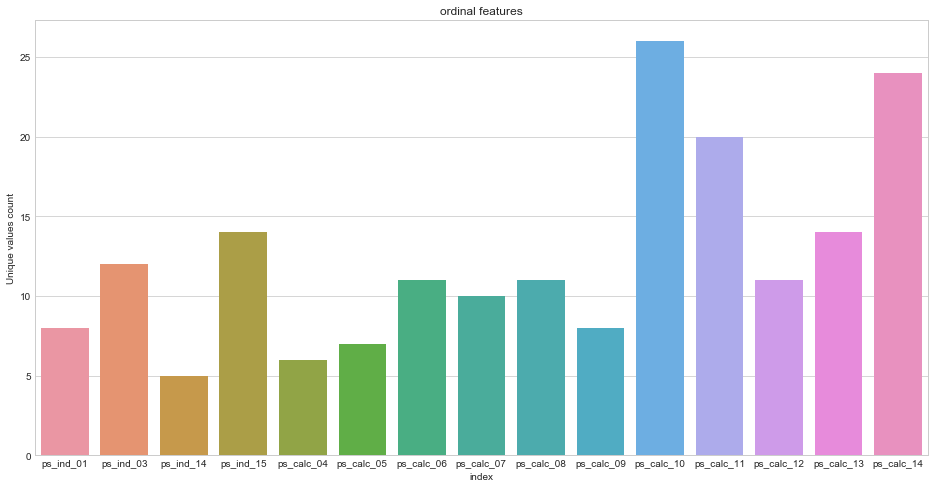

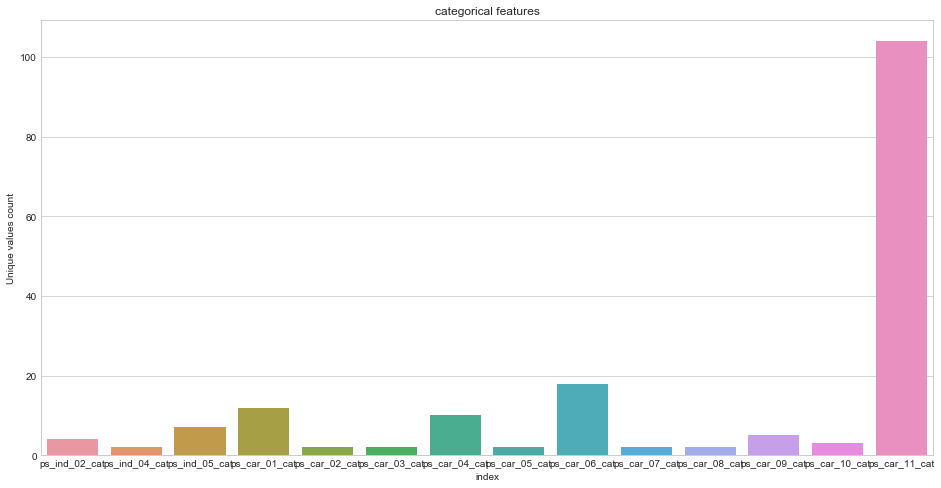

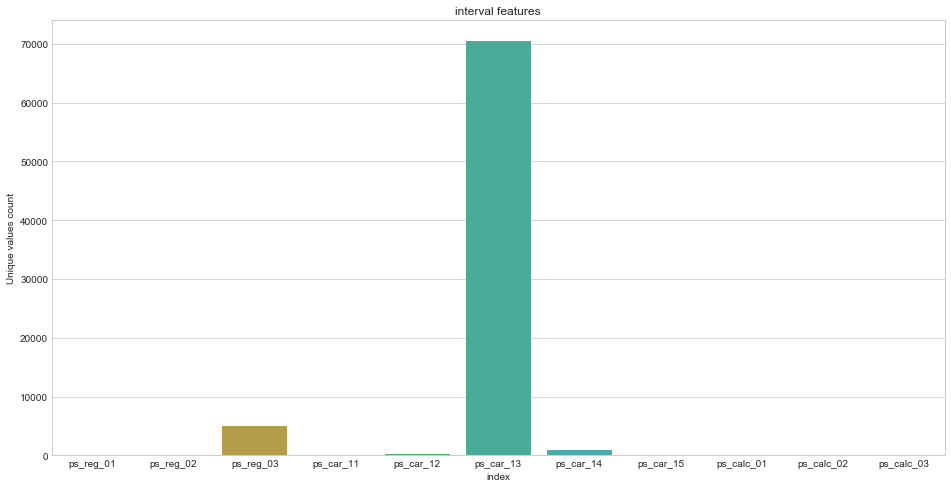

In [18]:
for f_type in ['ordinal', 'categorical', 'interval']:
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(f_type + ' features')    
    ax.set_xlabel('Name')
    sliced_data = unique_values[unique_values['f_type'] == f_type].reset_index()
    sns.set_style("whitegrid")
    sns.barplot(data=sliced_data, x='index', y='count', ax=ax)
    ax.set_ylabel('Unique values count')


##  A better look at features of type interval
The chart of these features is not so usefull as the unique values count is in range of 4 up to 70k.<br>In order to keep the chart informative, two extra steps are needed:
1. Split the data into 2 charts - features with low / high number of unique values.
2. Drop the highest value (ps_car_13 with 70482 unique values) so it is possible to notice the rest of the values.

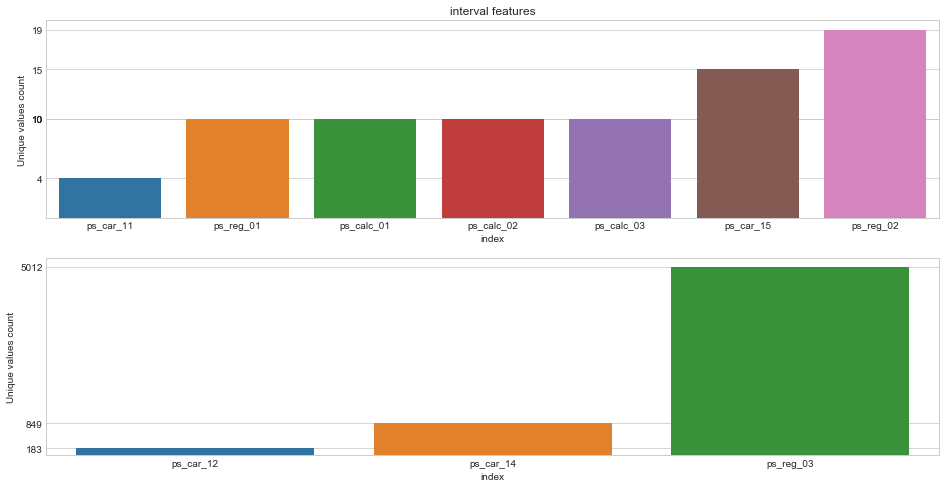

In [19]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
ax1.set_title('interval features')    
ax1.set_xlabel('Name')
sliced_data = unique_values[unique_values['f_type'] == 'interval'].reset_index().sort_values(by='count')
sliced_data_start = sliced_data[:-4]
sliced_data_end = sliced_data[-4:-1]
ax1.set_yticks(sliced_data_start['count'].values)
sns.set_style("whitegrid")
sns.barplot(data=sliced_data_start, x='index', y='count', ax=ax1)
ax1.set_ylabel('Unique values count')

ax2.set_yticks(sliced_data_end['count'].values)
sns.barplot(data=sliced_data_end, x='index', y='count', ax=ax2, )
ax2.set_ylabel('Unique values count')


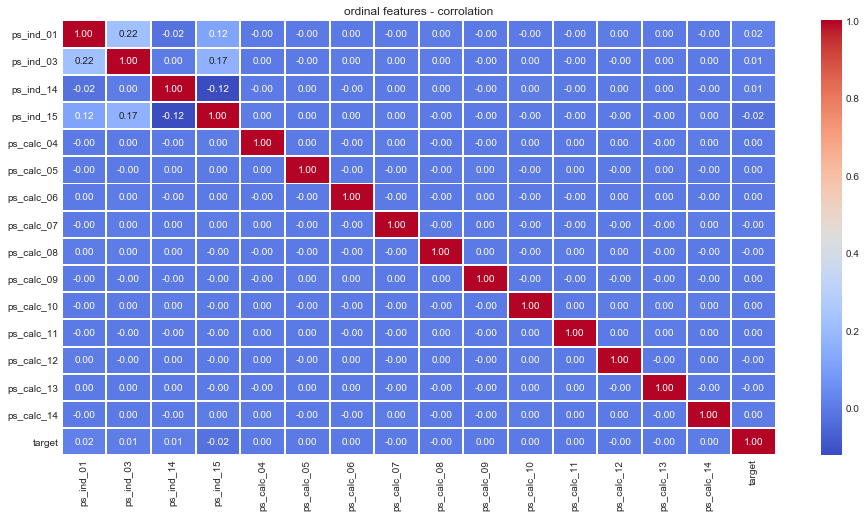

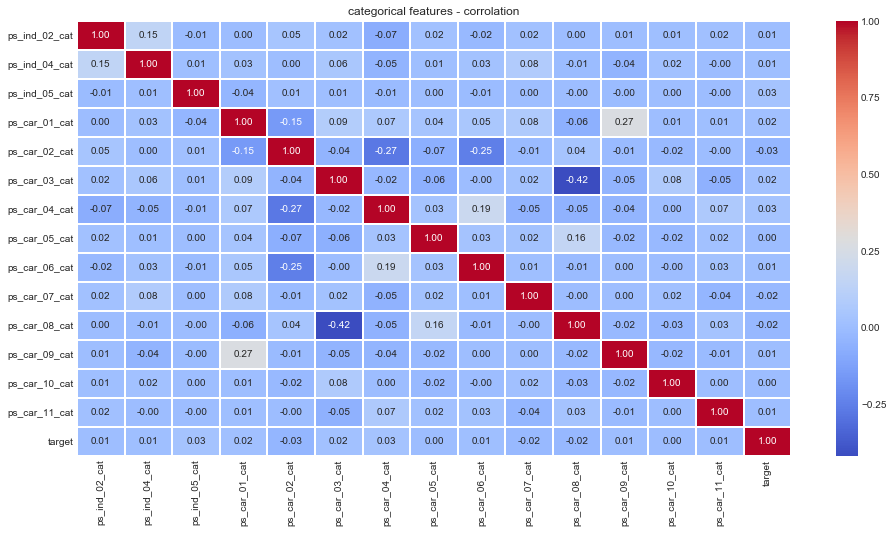

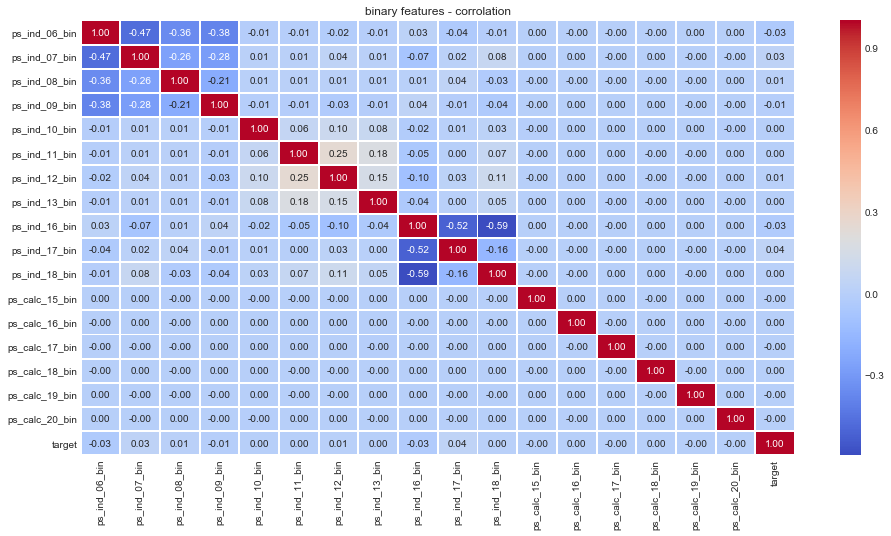

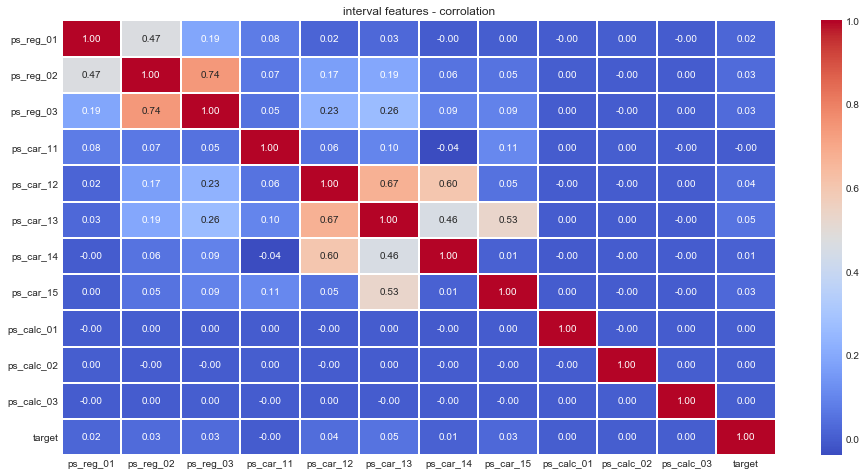

In [20]:
for f_type in unique_values['f_type'].unique():
    sliced_features = list(unique_values[unique_values['f_type'] == f_type].index)
    sliced_features.append('target')
    sliced_data = train_dataset[sliced_features]
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(f_type + ' features - corrolation')    
    sns.heatmap(data=sliced_data.corr(), ax=ax, annot=True, fmt = ".2f", cmap = "coolwarm", linewidths=1)

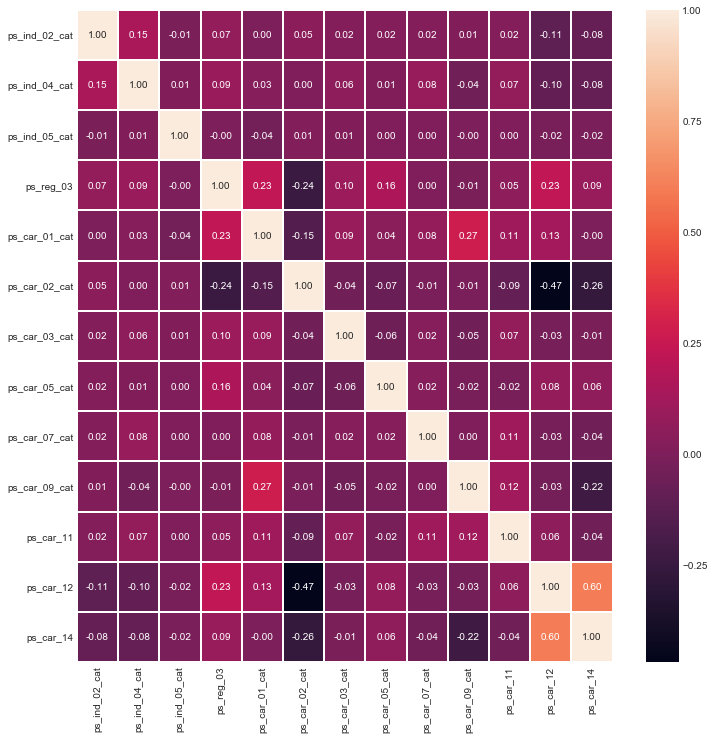

In [21]:
unique_values_with_missing = unique_values[unique_values.missing_values > 0]
train_dataset[unique_values_with_missing.index]
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(train_dataset[unique_values_with_missing.index].corr(), fmt='.2f', annot=True, linewidths=1, ax=ax)

corr = train_dataset.corr()
most_corr = {}
for col in unique_values_with_missing.index.values:
    sorted_corr = corr.sort_values(by=col, ascending=False)
    most_corr[col] = sorted_corr[col][1:5].reset_index().values
#display(most_corr)

In [22]:
corr_df = pd.DataFrame(data={'Name':list(most_corr.keys())})
#corr_df['']
vals = np.array(list(most_corr.values()))
vals[:,1,:]
#corr_df

array([['target', 0.03225434962133573],
       ['ps_ind_02_cat', 0.04538626468618831],
       ['ps_ind_02_cat', 0.14636321149097664],
       ['ps_car_07_cat', 0.11444189883205855],
       ['ps_car_14', 0.6033609356447661],
       ['ps_car_11', 0.11945875705111156],
       ['ps_car_04_cat', 0.5128168075007111],
       ['ps_car_13', 0.21376604075338096],
       ['ps_ind_09_bin', 0.11055315874893111],
       ['ps_car_13', 0.2648004623475134],
       ['ps_reg_02', 0.2314625774480472],
       ['ps_ind_04_cat', 0.08423180061346618],
       ['ps_reg_03', 0.1599895795760863]], dtype=object)

In [23]:
# Need to make a df from it with the top corrolated features for each feature that has missing values
# Next sstep is to fill the missing values according to the values of the same feature in rows where the corrolated other features are th smae

aa = np.array(list(most_corr.items()))[:,1]
aa[:]

array([ array([['ps_ind_03', 0.03811155506640186],
       ['target', 0.03225434962133573],
       ['ps_car_02_cat', 0.014032840437324315],
       ['ps_ind_04_cat', 0.01254679813306304]], dtype=object),
       array([['ps_ind_06_bin', 0.13639743705729562],
       ['ps_ind_02_cat', 0.04538626468618831],
       ['ps_ind_09_bin', 0.039961187243307425],
       ['ps_car_08_cat', 0.03606567287469101]], dtype=object),
       array([['ps_ind_07_bin', 0.30513060109851486],
       ['ps_ind_02_cat', 0.14636321149097664],
       ['ps_reg_03', 0.09478337300391913],
       ['ps_car_07_cat', 0.08423180061346618]], dtype=object),
       array([['ps_car_09_cat', 0.11945875705111156],
       ['ps_car_07_cat', 0.11444189883205855],
       ['ps_car_01_cat', 0.11088249849066975],
       ['ps_car_15', 0.1096801762596568]], dtype=object),
       array([['ps_car_13', 0.6720140732364945],
       ['ps_car_14', 0.6033609356447661],
       ['ps_car_04_cat', 0.5704360113120069],
       ['ps_car_06_cat', 0.273648897

In [24]:
train_dataset['ps_car_03_cat'].value_counts()

1.0    110709
0.0     73272
Name: ps_car_03_cat, dtype: int64

In [25]:
# Drop nulls - 
print('Data size with nulls', train_dataset.shape)
# Drop columns with more than 15% missing values

too_many_missing_values_cols = nulls_df[nulls_df.Nulls_ratio > 20].index.values
print('Features with more than 20% missing values', too_many_missing_values_cols)

train_dataset = train_dataset.drop(too_many_missing_values_cols, axis=1)
print('Data size after droppint columns with more than 20% missing values', train_dataset.shape)
# Dropping rows with missing values
train_dataset = train_dataset.dropna(axis=0)
print('Data size after droppint rows that contain missing values', train_dataset.shape)

Data size with nulls (595212, 59)
Features with more than 20% missing values ['ps_car_03_cat' 'ps_car_05_cat']
Data size after droppint columns with more than 20% missing values (595212, 57)
Data size after droppint rows that contain missing values (443531, 57)


In [26]:
# Categorical features encoding
#from sklearn.preprocessing import OneHotEncoder#,LabelEncoder
#lbl = LabelEncoder()
#ohe = OneHotEncoder()

#print(categorical_features)
#ohe.fit(train_dataset[['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat']])
#ohe.transform(train_dataset[['ps_ind_02_cat']])
#display(ohe.transform(train_dataset[['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat']]))
#train_dataset[['ps_ind_02_cat']].get_dummies()
#a = train_dataset['ps_calc_01']
categorical_features = [f for f in train_dataset.columns if '_cat' in f]
train_dataset = pd.get_dummies(train_dataset, columns=categorical_features, prefix=categorical_features)
#train_dataset[categorical_features]

In [67]:
class_1_data = train_dataset[train_dataset.target == 1]
class_0_data = train_dataset[train_dataset.target == 0].sample(len(class_1_data))
under_sampled_data = pd.concat([class_0_data, class_1_data], axis=0)
class_0_data.shape, class_1_data.shape, under_sampled_data.shape, under_sampled_data.target.value_counts()
train_dataset = under_sampled_data

In [68]:
# Train test split
from sklearn.model_selection import train_test_split
X = train_dataset[train_dataset.columns[2:]]
y = train_dataset[train_dataset.columns[1]]
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)
y_train.value_counts(), y_validation.value_counts(), X_train.shape

(0    13173
 1    13107
 Name: target, dtype: int64, 1    3318
 0    3252
 Name: target, dtype: int64, (26280, 212))

In [69]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', y.unique(), y)
scale_pos_weight = weights[1]/weights[0]
scale_pos_weight, weights

(1.0, array([ 1.,  1.]))

In [32]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, learning_rate=0.2, gamma=0.007 ,
                    n_estimators=30, min_child_weight=5,
                    max_depth=3, scale_pos_weight=scale_pos_weight,# subsample=0.8,colsample_bytree=0.8,
                    verbose=2)#, eval_metric=['xgb_normalizedgini', 'logloss'])


In [80]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=7, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=10, missing=None, n_estimators=600,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=scale_pos_weight, seed=118, silent=True,
       subsample=1.0)

In [81]:
xgb.fit(X_train, y_train ,eval_metric=gini_xgb)
print('Finished training')


Finished training


In [82]:
y_pred = xgb.predict(X_validation)
y_pred_prob = xgb.predict_proba(X_validation)


y_pred_train = xgb.predict(X_train)
y_pred_prob_train = xgb.predict_proba(X_train)

In [83]:
"""from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, learning_rate=0.02, gamma=0.007 ,
                    n_estimators=100, min_child_weight=5, silent=False, 
                    max_depth=3, scale_pos_weight=scale_pos_weight,# subsample=0.8,colsample_bytree=0.8,
                    verbose=2, eval_metric=['auc'])
xgb.fit(X_train, y_train, eval_metric=gini_xgb)
print('Finished training')
y_pred = xgb.predict(X_validation)
y_pred_prob = xgb.predict_proba(X_validation)
y_pred_train = xgb.predict(X_train)
y_pred_prob_train = xgb.predict_proba(X_train)"""

"from xgboost import XGBClassifier\nxgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, learning_rate=0.02, gamma=0.007 ,\n                    n_estimators=100, min_child_weight=5, silent=False, \n                    max_depth=3, scale_pos_weight=scale_pos_weight,# subsample=0.8,colsample_bytree=0.8,\n                    verbose=2, eval_metric=['auc'])\nxgb.fit(X_train, y_train, eval_metric=gini_xgb)\nprint('Finished training')\ny_pred = xgb.predict(X_validation)\ny_pred_prob = xgb.predict_proba(X_validation)\ny_pred_train = xgb.predict(X_train)\ny_pred_prob_train = xgb.predict_proba(X_train)"

In [84]:
from sklearn.metrics import confusion_matrix, classification_report
display(confusion_matrix(y_train, y_pred_train))
display(classification_report(y_train, y_pred_train))

display(confusion_matrix(y_validation, y_pred))
display(classification_report(y_validation, y_pred))
print(eval_gini(y_validation, y_pred_prob[:, 1]))
print(eval_gini(y_train, y_pred_prob_train[:, 1]))

array([[8680, 4493],
       [5622, 7485]], dtype=int64)

'             precision    recall  f1-score   support\n\n          0       0.61      0.66      0.63     13173\n          1       0.62      0.57      0.60     13107\n\navg / total       0.62      0.62      0.61     26280\n'

array([[2047, 1205],
       [1513, 1805]], dtype=int64)

'             precision    recall  f1-score   support\n\n          0       0.57      0.63      0.60      3252\n          1       0.60      0.54      0.57      3318\n\navg / total       0.59      0.59      0.59      6570\n'

0.23874379340538432
0.3238640868390207


In [56]:
pd.DataFrame(data={'Feature':X_train.columns.values, 'Importance':xgb.feature_importances_}).sort_values(by=['Importance'], ascending=False)

,Feature,Importance
20,ps_car_13,0.101017
17,ps_reg_03,0.078488
1,ps_ind_03,0.067587
21,ps_car_14,0.050872
11,ps_ind_15,0.050872
36,ps_calc_14,0.029797
32,ps_calc_10,0.026163
0,ps_ind_01,0.026163
16,ps_reg_02,0.025436
13,ps_ind_17_bin,0.023256


In [ ]:
feature_importances = pd.DataFrame(data={'Feature':X_train.columns.values, 'Importance':xgb.feature_importances_}).sort_values(by=['Importance'], ascending=False)
features_to_drop = feature_importances[feature_importances['Importance'] < 0.01]['Feature']
features_to_drop
train_dataset.drop(features_to_drop.values, axis=1, inplace=True)

In [ ]:
pd.DataFrame(data={'Feature':X_train.columns.values, 'Importance':xgb.feature_importances_}).sort_values(by=['Importance'], ascending=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, max_depth=8, min_samples_leaf=4, 
                            max_features=0.2, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, y_train)
print('Finished training')
y_pred = xgb.predict(X_validation)

y_pred_train = xgb.predict(X_train)

In [ ]:
display(confusion_matrix(y_train, y_pred_train))
display(classification_report(y_train, y_pred_train))

display(confusion_matrix(y_validation, y_pred))
display(classification_report(y_validation, y_pred))

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',
                    n_jobs=-1)

In [ ]:
# Random search with K fold cross validation

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'scale_pos_weight': [scale_pos_weight/10, scale_pos_weight/5, scale_pos_weight],
        'learning_rate':[0.01, 0.03, 0.05, 0.1, 0.2],
        'n_estimators': [30, 100, 230]
        }

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params,
                                   n_iter=param_comb, scoring='roc_auc',
                                   n_jobs=-1,
                                   cv=skf.split(X,y),
                                   verbose=10, random_state=1001, fit_params={'eval_metric':gini_xgb})

# Here we go
#start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
#timer(start_time) # timing ends here for "start_time" variabl

In [ ]:
random_search.best_estimator_

In [ ]:
xgb = random_search.best_estimator_